In [52]:
import warnings
import pandas as pd
import urllib.request
import numpy as np
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from textwrap import wrap
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import glob
from textwrap import wrap


## Load the data

In [141]:
# TCGA dictionary information
tcga_dict = open("./data/tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 5:
        code_to_disease = eval(line)
        

In [162]:
def getDataAndLabels(name, features, label_encoder):
    labels_string = features.cancer_type
   
    labels        = label_encoder.fit_transform(labels_string)

    # Get rid of the cancer type and patient_id columns 
    data = features[features.columns[3:]]
    return {'name': name, 'feature_size': data.shape[1],
            'data': data, 'labels': labels , 'label_encoder': label_encoder }

In [163]:
print('Loading training data ...')
# label encoder
label_encoder   = preprocessing.LabelEncoder()

# get all file names that start with features_
train_files = glob.glob("./data/features_*.train.csv")
all_train_data = {}

# load all of the files
for filename in train_files:
    
    name = filename[16:-10]
    print(" ", name)
    train_features = pd.read_csv(filename)
    all_train_data[name] = getDataAndLabels(name, train_features, label_encoder)

print("done.")

Loading training data ...
  l1reg_c1
  l1reg_c100
  l1reg_c0.5
  l1reg_c10
  topgenes_small
  bestfit_med
  bestfit_large
  all
  bestfit_with_topgenes
done.


In [164]:
print('Loading test data ...')

test_files = glob.glob("./data/features_*.test.csv")
all_test_data = {}
for filename in test_files:
    
    name = filename[16:-9]
    print(" ", name)
    test_features = pd.read_csv(filename)
    all_test_data[name] = getDataAndLabels(name, test_features, label_encoder)

print("done.")

Loading test data ...
  l1reg_c10
  topgenes_small
  bestfit_large
  l1reg_c0.5
  l1reg_c100
  l1reg_c1
  bestfit_med
  bestfit_with_topgenes
  all
done.


## Functions that perform GridSearch to find optimal hyper-parameters for classifiers

In [165]:
def getBestParamsLogit(train_data, train_labels):
    #
    # Logistic Regression
    #
    lr = LogisticRegression(penalty='l2', multi_class = 'ovr', solver='liblinear', max_iter=150)
    params = {'C': [0.1, 0.25,  0.5,]}
    logit = GridSearchCV(lr, params, cv=5,
                         scoring='accuracy', return_train_score=True)

    # Fit  training data
    logit.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print(' Best param:', logit.best_params_)
    print(' Accuracy:  ', np.round(logit.best_score_, 4) )
    
    return logit.best_params_

In [166]:
def getBestParamsSVM(train_data, train_labels):
    #
    # SVM
    #
    classifier = LinearSVC(penalty='l2')

    params = {'C': [0.01, 0.1, 0.5]}
    svm = GridSearchCV(classifier, params, cv=4, 
                       scoring='accuracy', return_train_score=True)

    # Fit  training data
    svm.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print(' Best param:', svm.best_params_)
    print(' Accuracy:  ', np.round(svm.best_score_, 4) )
    
    return svm.best_params_

## Run the different classifiers 

In [167]:
def runClassifiers(train_data, train_labels, test_data, test_labels, name, hyper_params, scores):

    if name in hyper_params and 'lr' in hyper_params[name]:
        best_params_logit = hyper_params[name]['lr']
    else:
        print("Running grid search on Logistic Regression...")
        best_params_logit = getBestParamsLogit(train_data, train_labels)

    if name in hyper_params and 'svm' in hyper_params[name]:
        best_params_svm = hyper_params[name]['svm']
    else:
        print("Running grid search on Linear SVM...")
        best_params_svm = getBestParamsSVM(train_data, train_labels)


    # Run logistic regression with L2 regularization on reduced
    # feature set
    lr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                            C=best_params_logit['C'], 
                            solver="liblinear", multi_class="ovr")
    lr.fit(train_data, train_labels) 
    predict = lr.predict(test_data)

    # Get precision, recall, f1 scores
    logit_prf_scores      = precision_recall_fscore_support(test_labels, predict, average='weighted')
    logit_scores_by_label = precision_recall_fscore_support(test_labels, predict, average=None)

    # Get confusion matrix
    logit_confusion       = confusion_matrix(test_labels, predict)

        
    #
    # Run Linear SVM
    #
    svm = LinearSVC(penalty='l2', C=best_params_svm['C'])

    svm.fit(train_data, train_labels,) 
    predict = svm.predict(test_data)

    # Get precision, recall, f1 scores
    svm_prf_scores      = precision_recall_fscore_support(test_labels, predict, average='weighted')
    svm_scores_by_label = precision_recall_fscore_support(test_labels, predict, average=None)

    # Get confusion matrix
    svm_confusion       = confusion_matrix(test_labels, predict)

    print("\nLogistic Regression", name)
    print("  precision:", np.round(logit_prf_scores[0], 4))  
    print("  recall:   ", np.round(logit_prf_scores[1], 4))  
    print("  f1:       ", np.round(logit_prf_scores[2], 4))  

    print("\nLinear SVM", name)
    print("  precision:", np.round(svm_prf_scores[0], 4))  
    print("  recall:   ", np.round(svm_prf_scores[1], 4))  
    print("  f1:       ", np.round(svm_prf_scores[2], 4))  
    
    scores[name] = {
        'lr': [
            logit_prf_scores[0],
            logit_prf_scores[1],
            logit_prf_scores[2],
            logit_scores_by_label,
            logit_confusion
        ],
        'svm': [
            svm_prf_scores[0],
            svm_prf_scores[1],
            svm_prf_scores[2],
            svm_scores_by_label,
            svm_confusion
        ]
    }
    

In [153]:
hyper_params = {
    'l1reg_c0.5':           {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'l1reg_c1':             {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'l1reg_c10':            {'lr': {'C': 0.1},  'svm': {'C': 0.01}},
    'l1reg_c100':           {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'topgenes_small':       {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'bestfit_med':          {'lr': {'C': 0.1 }, 'svm': {'C': 0.01}},
    'bestfit_large':        {'lr': {'C': 0.1 }, 'svm': {'C': 0.01}},
    'all':                  {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'bestfit_with_topgenes':{'lr': {'C': 0.1 }, 'svm': {'C': 0.01}}
}


scores = {}


for name in all_train_data.keys():
    print("************************")
    print(name)
    print("************************")

    train      = all_train_data[name]
    test       = all_test_data[name]

    runClassifiers(train['data'], train['labels'], test['data'], test['labels'], name, hyper_params, scores)

************************
l1reg_c1
************************


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression l1reg_c1
  precision: 0.5681
  recall:    0.5445
  f1:        0.5322

Linear SVM l1reg_c1
  precision: 0.5478
  recall:    0.548
  f1:        0.5287
************************
l1reg_c100
************************


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression l1reg_c100
  precision: 0.5681
  recall:    0.5465
  f1:        0.5277

Linear SVM l1reg_c100
  precision: 0.5521
  recall:    0.55
  f1:        0.5305
************************
l1reg_c0.5
************************


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression l1reg_c0.5
  precision: 0.552
  recall:    0.5385
  f1:        0.5268

Linear SVM l1reg_c0.5
  precision: 0.5404
  recall:    0.5425
  f1:        0.5241
************************
l1reg_c10
************************


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression l1reg_c10
  precision: 0.5743
  recall:    0.5514
  f1:        0.5304

Linear SVM l1reg_c10
  precision: 0.5488
  recall:    0.5475
  f1:        0.5292
************************
topgenes_small
************************


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression topgenes_small
  precision: 0.5569
  recall:    0.535
  f1:        0.5204

Linear SVM topgenes_small
  precision: 0.5423
  recall:    0.537
  f1:        0.5192
************************
bestfit_med
************************


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression bestfit_med
  precision: 0.5603
  recall:    0.531
  f1:        0.519

Linear SVM bestfit_med
  precision: 0.53
  recall:    0.5275
  f1:        0.5111
************************
bestfit_large
************************


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression bestfit_large
  precision: 0.5681
  recall:    0.5425
  f1:        0.5256

Linear SVM bestfit_large
  precision: 0.5437
  recall:    0.538
  f1:        0.523
************************
all
************************


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression all
  precision: 0.5706
  recall:    0.5504
  f1:        0.5313

Linear SVM all
  precision: 0.549
  recall:    0.547
  f1:        0.5273
************************
bestfit_with_topgenes
************************


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression bestfit_with_topgenes
  precision: 0.5603
  recall:    0.531
  f1:        0.519

Linear SVM bestfit_with_topgenes
  precision: 0.53
  recall:    0.5275
  f1:        0.5111


/Users/tonyd/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Visualize Performance across different feature sets, different classifiers

In [168]:
colors = {'lr': 'olivedrab', 'svm': 'slateblue'}

df_scores = pd.DataFrame(scores)
rows = []
for name in all_train_data.keys():    
    rows.append([name,
                 all_train_data[name]['feature_size'],
                'lr',
                df_scores.loc['lr'][name][0],
                df_scores.loc['lr'][name][1],
                df_scores.loc['lr'][name][2]])
for name in all_train_data.keys():    
    rows.append([name,
                 all_train_data[name]['feature_size'],
                'svm',
                df_scores.loc['svm'][name][0],
                df_scores.loc['svm'][name][1],
                df_scores.loc['svm'][name][2]])

df_report = pd.DataFrame(rows, columns=['name', 'feature_size', 'classifier', 'precision', 'recall', 'f1'])


In [170]:
def plot_classifier_metrics(df_report, label_encoder):
    
    plt.rcParams["figure.figsize"] = (20,6)

    labels = []
    for key, group in df_report.groupby(['feature_size', 'name']):
        labels.append(str(key[0]) + '\n' + key[1])

        
    for classifier, group in df_report.groupby(['classifier']):

        plt.plot(labels, group.precision.values, color=colors[classifier], 
                 linewidth=3, label=classifier + " precision", marker='o' )
        plt.plot(labels, group.recall.values, color=colors[classifier], linestyle="dashed",
                 linewidth=3, label=classifier + " recall", marker='o' )
    

    plt.yticks(np.arange(.42, .65, .01))
    plt.ylabel('Precision, Recall', fontsize=20)
    plt.xlabel('Precision and Recall across different Features and Classifiers', fontsize=20, labelpad=20)
    plt.legend()
    plt.grid()
    plt.show()

    

In [175]:
def show_precision_recall_by_label(precision_by_label, recall_by_label, name, classifier, label_encoder):

    labels = []
    for i in range(len(precision_by_label)):
        label = label_encoder.inverse_transform([i])[0]
        labels.append(label)
    
    y_pos = np.arange(len(labels))    

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

    ax1.invert_xaxis()
    ax1.yaxis.tick_right()
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
        
    ax1.barh(y_pos, precision_by_label, color=colors[classifier] , label="precision")
    ax2.barh(y_pos, recall_by_label,    color=colors[classifier],  label='recall')

    ax1.set_title('Precision( ' + classifier + ')')
    ax2.set_title('Recall (' + classifier + ')')
    
    plt.grid()
    plt.show()

In [188]:
def coords_of_max(theArray, n):
    # Flatten the 2D array
    flat = theArray.flatten()
    # Partition so that the we know the sort order for
    # the cells with the highest values.  We just
    # care about the top n highest values.  So for example,
    # if n = 3, get return 3 indices.  
    indices = np.argpartition(flat, -n)[-n:]
    # Reverse so that we show index of highest value first
    # (descending)
    indices = indices[np.argsort(-flat[indices])]
    # Now return the coordinates for these indices
    # for a 2D array.  This will return 2 arrays,
    # the first for the row index, the second for the
    # column index.  The row index represents the
    # actual digit, the column index represents
    # the confused digit
    return np.unravel_index(indices, theArray.shape)

In [189]:
def show_confusion_matrix(conf_mx, label_encoder):
    # Determine the error rates for each misclassification pair
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    # Set the error rates for correctly classified pairs (the diagonal) to zero
    np.fill_diagonal(norm_conf_mx, 0)
    
    max_coords = coords_of_max(norm_conf_mx, 20)
    confusion_rows = []
    for i in range(len(max_coords[0])):

        # This is the actual label
        actual_label_idx  = max_coords[0][i]
        actual_label      = label_encoder.inverse_transform([actual_label_idx])[0]

        # This is the predicted label
        predicted_label_idx = max_coords[1][i]
        predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]
        
        # This is the error rate
        error_rate  = norm_conf_mx[max_coords[0][i], max_coords[1][i]]
        error_count = conf_mx[max_coords[0][i], max_coords[1][i]]

        row = list([ actual_label,                     
                     predicted_label,
                     code_to_disease[actual_label][0], 
                     code_to_disease[predicted_label][0], 
                     error_rate, 
                     error_count ])
        confusion_rows.append(row)
    
    df = pd.DataFrame(confusion_rows, columns=['actual', 'predicted',  'actual_name', 'predicted_name', 'error_rate', 'error_count'])
    display(df)

        

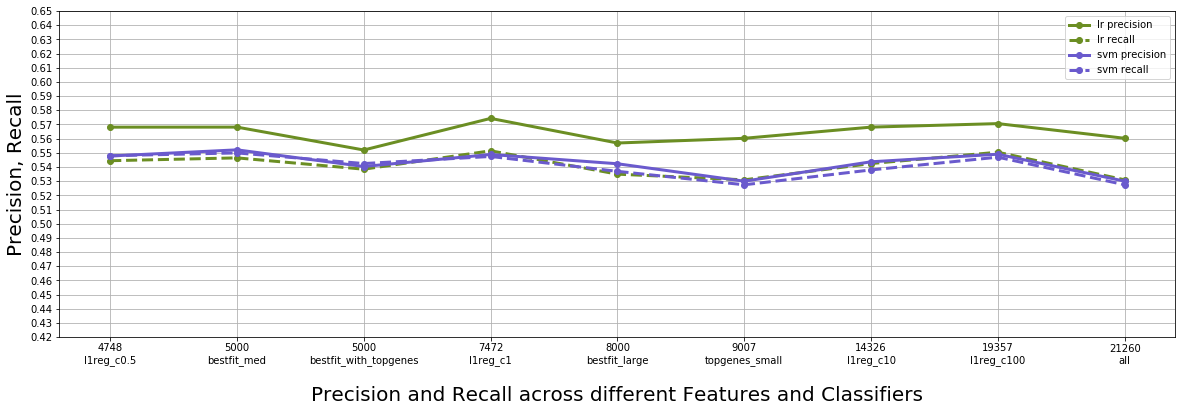

In [171]:
# Plot precision and accuracy across different classifiers
plot_classifier_metrics(df_report, label_encoder)



Best precision


,name,feature_size,classifier,precision,recall,f1
3,l1reg_c10,14326,lr,0.574294,0.551449,0.530438




Best recall


,name,feature_size,classifier,precision,recall,f1
3,l1reg_c10,14326,lr,0.574294,0.551449,0.530438




Best f1


,name,feature_size,classifier,precision,recall,f1
0,l1reg_c1,7472,lr,0.568115,0.544456,0.53216




Precision and Recall by Label for classifier 
Classifier: lr Feature set: l1reg_c10


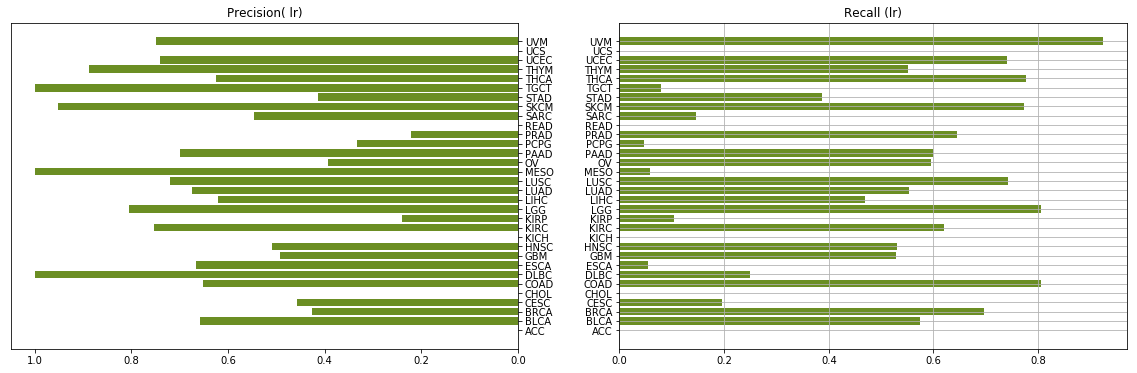

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.750000,21
1,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.534884,23
2,ACC,BRCA,Adrenocortical_carcinoma,Breast_invasive_carcinoma,0.466667,7
3,UCS,UCEC,Uterine_Carcinosarcoma,Uterine_Corpus_Endometrial_Carcinoma,0.461538,6
4,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.440000,11
5,CESC,BRCA,Cervical_squamous_cell_carcinoma_and_endocervi...,Breast_invasive_carcinoma,0.375000,21
6,MESO,BRCA,Mesothelioma,Breast_invasive_carcinoma,0.352941,6
7,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.307692,4
8,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.294118,5
9,PCPG,THCA,Pheochromocytoma_and_Paraganglioma,Thyroid_carcinoma,0.279070,12


In [190]:
# best precision
sorted_df = df_report.sort_values(by='precision', ascending=0)
best_precision = sorted_df.head(1)

# best recall
sorted_df = df_report.sort_values(by='recall', ascending=0)
best_recall = sorted_df.head(1)

# best f1
sorted_df = df_report.sort_values(by='f1', ascending=0)
best_f1 = sorted_df.head(1)

# Show the feature set and classifier with the best 
# precision, recall, and f1 scores
print("\n\nBest precision")
display(best_precision)
print("\n\nBest recall")
display(best_recall)
print("\n\nBest f1")
display(best_f1)

# get the scores by label and confusion matrix
# for the best prediction
best_prediction = best_precision
best_name       = best_prediction.name.values[0]
best_classifier = best_prediction.classifier.values[0]
precision_by_label = scores[best_name][best_classifier][3][0]
recall_by_label = scores[best_name][best_classifier][3][1]
confusion_matrix = scores[best_name][best_classifier][4]

# show a side-by-side barchart of precision and recall for each label
print("\n\nPrecision and Recall by Label for classifier ")
print("Classifier:", best_classifier, "Feature set:", best_name)
show_precision_recall_by_label(precision_by_label, recall_by_label,
                               best_name, best_classifier, label_encoder)
                                                      
                                                      
# show the confusion matrix for the best performing classifier/feature set
show_confusion_matrix(confusion_matrix, label_encoder)                                                      
